In [92]:
import pandas as pd
from pathlib import Path
import csv
import matplotlib.pylab as plt
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix


In [30]:
!ls
# you should see you are in the mainfolder 

 CodeSnippets.txt	      network-commons-analysis.ipynb   Untitled.ipynb
 data			      network-commons.nlogo
'Experiments Parameters.md'   README.md


In [102]:
# global parameters related to the structure of the file
# other global variables (like 'path')

col_names_index = ['[run number]','[step]' ]
col_names_parameters = ['nb-villagers', 'LINK-TRANSMISSION-DISTANCE','min-degree', 'adaptive-harvest?',
                       'network-type', 'MIN-RSC-SAVING-PCT', 'wiring-probability',
                       'regrowth-chooser', 'INIT-HARVEST-LEVEL','DECREASE-PCT', 'INCREASE-PCT',
                       'MAX-TURTLE-BACKPACK','HFC-TICKER-MAX','HFC-TICKER-STOP','HFC-TICKER-START',
                        'PRL-TICKER-MAX','PRL-TICKER-STOP','PRL-TICKER-START','FACTOR-DIV',
                        'PERCENT-BEST-LAND','regrowth-chooser','MAX-TURTLE-VISION'
                       ]
col_names_reporters = ['total-resource-reporter','total-patch-regrowth','total-turtle-resource-reporter',
                       'total-quantity-harvested','number-of-hungry-turtles','total-wealth']
col_names_reporters_group = ['group-turtle-resource','group-turtle-wealth','group-turtle-prl',
                             'group-turtle-hfc']
col_names_useless = ['show-link?','debugging-agentset?', 'debugging-agentset-nb','color-chooser',
                     'DEBUG-RATE','DEBUG','TURTLE-PROC-CHOOSER']
experiment_name=""

path = Path()   # sets path to the current directory

In [66]:
# read file
# please put all your files into /data folder 

filepath = path/'data'/'network-commons experiment#1.3  500 turtles BACKPACK 3-table.csv'

# read line 3 for experiment name (--> i== 2)

with open(filepath, "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for i, line in enumerate(reader):
        if i == 2:
            experiment_name = line
            break
            

# read whole file into a pandas

df = pd.read_csv(filepath, skiprows=6, sep=',',
                usecols=lambda x: x not in col_names_useless )


df.insert(0, 'experiment_name', experiment_name[0])
df.set_index(['experiment_name']+col_names_index, append=False, inplace=True)

df.head()

nb-villagers  \
experiment_name                        [run number] [step]                 
experiment#1.3  500 turtles BACKPACK 3 1            0                500   
                                                    1                500   
                                                    2                500   
                                                    3                500   
                                                    4                500   

                                                            LINK-TRANSMISSION-DISTANCE  \
experiment_name                        [run number] [step]                               
experiment#1.3  500 turtles BACKPACK 3 1            0                                1   
                                                    1                                1   
                                                    2                                1   
                                                    3                                1   
                                                    4                                1   

                                                            min-degree  \
experiment_name                        [run number] [step]               
experiment#1.3  500 turtles BACKPACK 3 1            0                2   
                                                    1                2   
                                                    2                2   
                                                    3                2   
                                                    4                2   

                                                            adaptive-harvest?  \
experiment_name                        [run number] [step]                      
experiment#1.3  500 turtles BACKPACK 3 1            0                    True   
                                                    1                    True   
                                                    2                    True   
                                                    3                    True   
                                                    4                    True   

                                                                       network-type  \
experiment_name                        [run number] [step]                            
experiment#1.3  500 turtles BACKPACK 3 1            0       preferential-attachment   
                                                    1       preferential-attachment   
                                                    2       preferential-attachment   
                                                    3       preferential-attachment   
                                                    4       preferential-attachment   

                                                            MIN-RSC-SAVING-PCT  \
experiment_name                        [run number] [step]                       
experiment#1.3  500 turtles BACKPACK 3 1            0                        3   
                                                    1                        3   
                                                    2                        3   
                                                    3                        3   
                                                    4                        3   

                                                            wiring-probability  \
experiment_name                        [run number] [step]                       
experiment#1.3  500 turtles BACKPACK 3 1            0                  0.16599   
                                                    1                  0.16599   
                                                    2                  0.16599   
                                                    3                  0.16599   
                                                    4                  0.16599   

                                                 

In [67]:
print(experiment_name)

['experiment#1.3  500 turtles BACKPACK 3']


In [83]:
# accessing a column 
df.loc[: , 'total-wealth']

df["total-wealth"]

experiment_name                         [run number]  [step]
experiment#1.3  500 turtles BACKPACK 3  1             0              0.000000
                                                      1              0.000000
                                                      2              0.000000
                                                      3             20.429250
                                                      4            113.012800
                                                                    ...      
                                                      4996      284118.921657
                                                      4997      284118.921657
                                                      4998      284118.921657
                                                      4999      284118.921657
                                                      5000      284121.707762
Name: total-wealth, Length: 5001, dtype: float64

In [84]:
# accessing 2 columns
df.loc[: , ['total-wealth', 'total-resource-reporter']]

df[["total-wealth", "total-resource-reporter"]]

total-wealth  \
experiment_name                        [run number] [step]                  
experiment#1.3  500 turtles BACKPACK 3 1            0            0.000000   
                                                    1            0.000000   
                                                    2            0.000000   
                                                    3           20.429250   
                                                    4          113.012800   
...                                                                   ...   
                                                    4996    284118.921657   
                                                    4997    284118.921657   
                                                    4998    284118.921657   
                                                    4999    284118.921657   
                                                    5000    284121.707762   

                                                            total-resource-reporter  
experiment_name                        [run number] [step]                           
experiment#1.3  500 turtles BACKPACK 3 1            0                  11605.000000  
                                                    1                  10512.784625  
                                                    2                   9821.091768  
                                                    3                   9296.499047  
                                                    4                   8889.588768  
...                                                                             ...  
                                                    4996                1368.390858  
                                                    4997                1338.509272  
                                                    4998                1325.273065  
                                                    4999                1326.746445  
                                                    5000                1341.164979  

[5001 rows x 2 columns]

In [70]:
# accessing the dataframe for a specific experiment 

df.xs('experiment#1.3  500 turtles BACKPACK 3')

nb-villagers  LINK-TRANSMISSION-DISTANCE  min-degree  \
[run number] [step]                                                         
1            0                500                           1           2   
             1                500                           1           2   
             2                500                           1           2   
             3                500                           1           2   
             4                500                           1           2   
...                           ...                         ...         ...   
             4996             500                           1           2   
             4997             500                           1           2   
             4998             500                           1           2   
             4999             500                           1           2   
             5000             500                           1           2   

                     adaptive-harvest?             network-type  \
[run number] [step]                                               
1            0                    True  preferential-attachment   
             1                    True  preferential-attachment   
             2                    True  preferential-attachment   
             3                    True  preferential-attachment   
             4                    True  preferential-attachment   
...                                ...                      ...   
             4996                 True  preferential-attachment   
             4997                 True  preferential-attachment   
             4998                 True  preferential-attachment   
             4999                 True  preferential-attachment   
             5000                 True  preferential-attachment   

                     MIN-RSC-SAVING-PCT  wiring-probability regrowth-chooser  \
[run number] [step]                                                            
1            0                        3             0.16599    always-regrow   
             1                        3             0.16599    always-regrow   
             2                        3             0.16599    always-regrow   
             3                        3             0.16599    always-regrow   
             4                        3             0.16599    always-regrow   
...                                 ...                 ...              ...   
             4996                     3             0.16599    always-regrow   
             4997                     3             0.16599    always-regrow   
             4998                     3             0.16599    always-regrow   
             4999                     3             0.16599    always-regrow   
             5000                     3             0.16599    always-regrow   

                     INIT-HARVEST-LEVEL  total-resource-reporter  \
[run number] [step]                                                
1            0                        1             11605.000000   
             1                        1             10512.784625   
             2                        1              9821.091768   
             3                        1              9296.499047   
             4                        1              8889.588768   
...                                 ...                      ...   
             4996                     1              1368.390858   
             4997                     1              1338.509272   
             4998                     1              1325.273065   
             4999                     1              1326.746445   
             5000                     1              1341.164979   

                     total-patch-regrowth  total-turtle-resource-reporter  \
[run number] [step]                                                         
1            0                   0.000000                        0.

In [73]:
# accessing the dataframe for a specific experiment and specific run

df.xs( ('experiment#1.3  500 turtles BACKPACK 3',1) )

,nb-villagers,LINK-TRANSMISSION-DISTANCE,min-degree,adaptive-harvest?,network-type,MIN-RSC-SAVING-PCT,wiring-probability,regrowth-chooser,INIT-HARVEST-LEVEL,total-resource-reporter,total-patch-regrowth,total-turtle-resource-reporter,total-quantity-harvested,number-of-hungry-turtles,total-wealth,group-turtle-resource,group-turtle-wealth,group-turtle-prl
[step],,,,,,,,,,,,,,,,,,
0,500,1,2,True,preferential-attachment,3,0.16599,always-regrow,1,11605.000000,0.000000,0.000000,0.000000,0,0.000000,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[53 26 86 23 21 30 24 49 31 39 57 29 76 28 56 ...
1,500,1,2,True,preferential-attachment,3,0.16599,always-regrow,1,10512.784625,935.550000,1043.315375,2027.765375,12,0.000000,[5.8500000000000005 9.3 10.9425 11.7 6.4499999...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[25 50 61.3075 45.3675 27 35 46.2 7.2 144 39 9...
2,500,1,2,True,preferential-attachment,3,0.16599,always-regrow,1,9821.091768,1251.000000,1988.558232,1942.692857,9,0.000000,[13.649999999999999 11.55 20.7825 13.499999999...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[35.495000000000005 24.349999999999998 52.605 ...
3,500,1,2,True,preferential-attachment,3,0.16599,always-regrow,1,9296.499047,1367.050000,2859.771703,1891.642722,5,20.429250,[14.559875000000003 10.245 12.59715 25.6232812...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.114575312499997...,[34.602125 22.05 20.5 52.653999999999996 25.10...
4,500,1,2,True,preferential-attachment,3,0.16599,always-regrow,1,8889.588768,1444.460000,3620.558431,1851.370278,3,113.012800,[29.649911875 21.37 12.165 24.3363215625 14.85...,[0 0.9499999999999993 0 0 0 3.3500000000000014...,[37.31961689062499 18 10 33.111418546875 27.66...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,500,1,2,True,preferential-attachment,3,0.16599,always-regrow,1,1368.390858,257.650000,114.373788,218.773646,499,284118.921657,[0 0 0 0 0 0 0 0 0 0 1.521548813404297 0 0 0 0...,[2286.1251069955274 1759.3066866678898 1747.31...,[0 0 0 0 0 0 0 0 0 0 0 32.41312796395918 0 0 0...
4997,500,1,2,True,preferential-attachment,3,0.16599,always-regrow,1,1338.509272,255.002328,121.192464,284.883914,499,284118.921657,[0 0 0 0 0 8.790838464181181 0 0 0 4.861969194...,[5752.38980590435 3899.963462568153 4026.09909...,[0 18.926750000000002 13.041706060108545 0 0 4...
4998,500,1,2,True,preferential-attachment,3,0.16599,always-regrow,1,1325.273065,252.045492,145.555034,265.281700,499,284118.921657,[0 0 0 0 0 0 0 0 0 0 3.381258743326214 0 0 3.1...,[1555.4929912612633 1502.4415237425947 1674.62...,[0 0 0 0 0 0 0 0 0 0 27.80321221086643 0 18.16...


In [77]:
# accessing the unique values of a dataframe index
# e.g. finding the distinct experiments and runs
# https://stackoverflow.com/questions/24495695/pandas-get-unique-multiindex-level-values-by-label

print(df.index.unique(level='[run number]'))

print(df.index.unique(level='experiment_name'))

for experiment in df.index.unique(level='experiment_name'):
    print("Working with experiment ", experiment)

Int64Index([1], dtype='int64', name='[run number]')
Index(['experiment#1.3  500 turtles BACKPACK 3'], dtype='object', name='experiment_name')
Working with experiment  experiment#1.3  500 turtles BACKPACK 3


In [93]:
def process_netlogo_experiments_dataframe(df):
    for experiment in df.index.unique(level='experiment_name'):
        print("Processing experiment ", experiment)
        for run_number in df.index.unique(level='[run number]'):
            print("..processing run number ", run_number)
            sliced_df=df.xs( (experiment,run_number) )
            generate_reporters_vs_time(sliced_df, experiment, run_number)
            generate_total_resource_plot(sliced_df, experiment, run_number)
            generate_resource_exchanged_plot(sliced_df, experiment, run_number)
            generate_qty_harvested_vs_regrown_plot(sliced_df, experiment, run_number)
            generate_final_turtle_group_plots(sliced_df, experiment, run_number)

In [94]:
def generate_reporters_vs_time(sdf, experiment, run_number):
    for col_name in col_names_reporters:
        my_plot(sdf, col_name, experiment, run_number)


In [100]:
def my_plot(sdf, col_name: str, experiment: str, run_number: int):
    print('...Graph of {0} vs ticks'.format(col_name))
    sdf.plot(figsize=(15, 6), y = col_name)
    plt.show()
    plt.savefig(path/'data'/'plots'/"{0}_{1}_{2}_vs_ticks.png".format(experiment, run_number, col_name));

In [104]:
def generate_total_resource_plot(sdf, experiment, run_number):
    pass
def generate_resource_exchanged_plot(sdf, experiment, run_number):
    pass
def generate_qty_harvested_vs_regrown_plot(sdf, experiment, run_number):
    pass
def generate_final_turtle_group_plots(sdf, experiment, run_number):
    pass

Processing experiment  experiment#1.3  500 turtles BACKPACK 3
..processing run number  1
...Graph of total-resource-reporter vs ticks


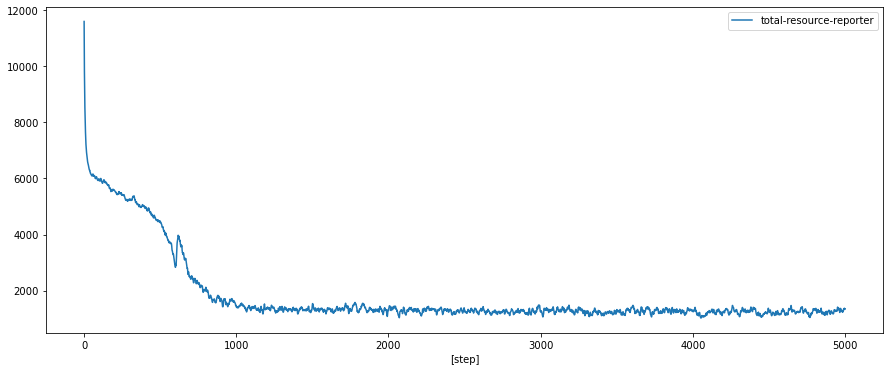

...Graph of total-patch-regrowth vs ticks


<Figure size 432x288 with 0 Axes>

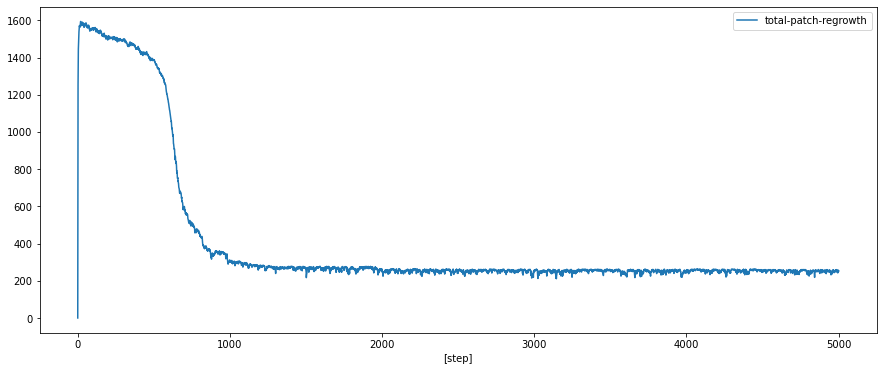

...Graph of total-turtle-resource-reporter vs ticks


<Figure size 432x288 with 0 Axes>

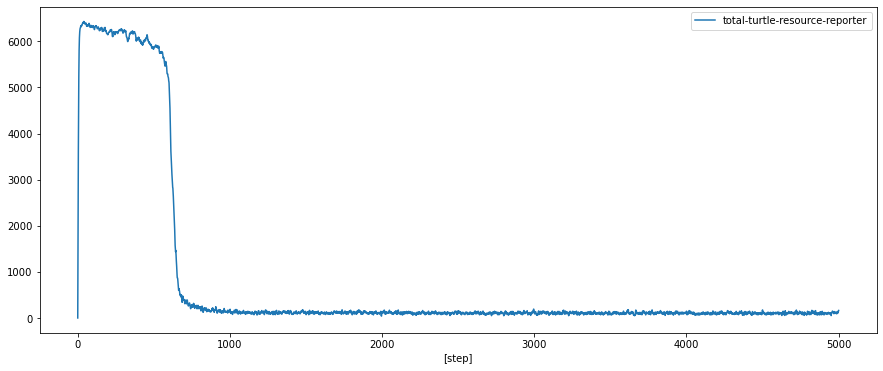

...Graph of total-quantity-harvested vs ticks


<Figure size 432x288 with 0 Axes>

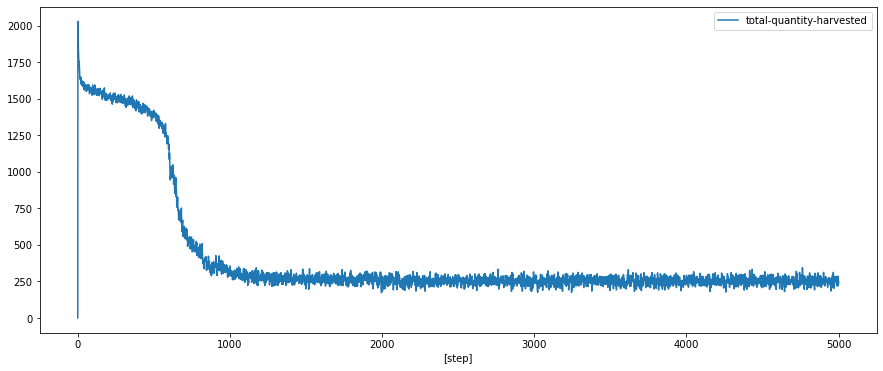

...Graph of number-of-hungry-turtles vs ticks


<Figure size 432x288 with 0 Axes>

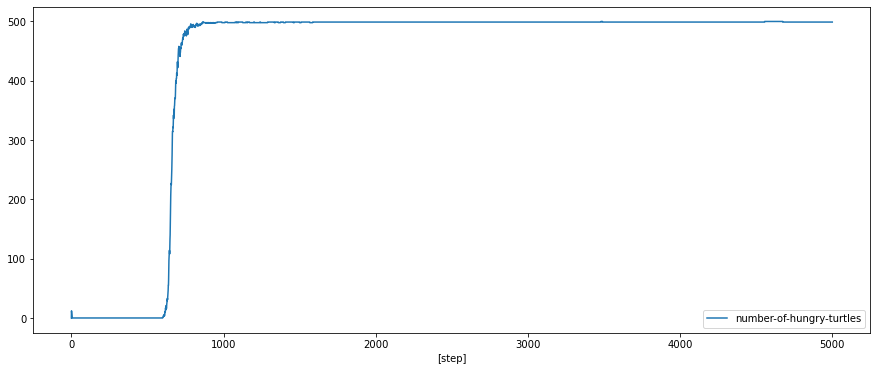

...Graph of total-wealth vs ticks


<Figure size 432x288 with 0 Axes>

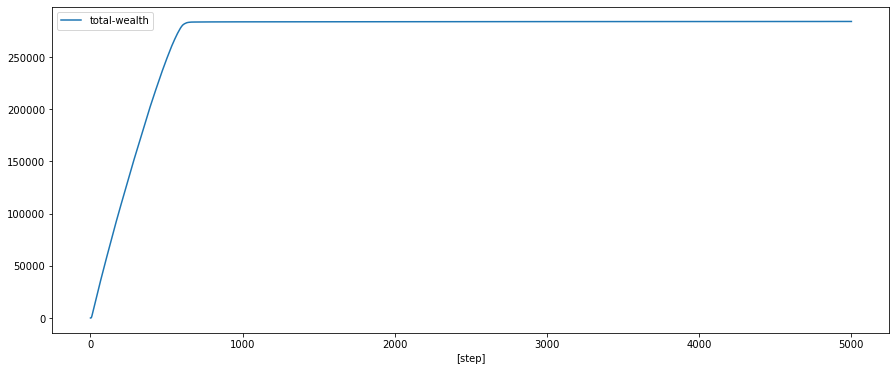

<Figure size 432x288 with 0 Axes>

In [105]:
# Calling the function to generate all sort of plots based on the csv file read

process_netlogo_experiments_dataframe(df)